In [1]:
#Pindah direktori ke direktori tempat data 
import os
path = 'E:\Daily Reanalisis ERA 5 v2'
os.chdir(path)

In [2]:
import warnings
warnings.simplefilter('ignore') #ignores simple warning

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.ticker as tk
import matplotlib.patches as mpatches
from scipy import stats

In [4]:
def bootstrap_3dxr(data, sample_size, n_samples, percentile):
    
    # create a list for sample means
    sample_means = []
    
    # loop n_samples times
    for i in tqdm(range(n_samples)):
        t=data.time
        trand=np.random.choice(t, size=sample_size, replace=False)
        datarandmean=data.sel(time=np.in1d(data.time,trand)).mean(dim='time')
        sample_means.append(datarandmean.values)
        
    low=np.percentile(sample_means,percentile/2, axis=0)
    high=np.percentile(sample_means,100-percentile/2, axis=0)
    
    return low, high #2D low and high threshold

In [5]:
#Read time-event excel data
censevt=pd.read_excel('calculation_output\CENS Event 3 days Running Mean.xlsx')
censevt=censevt.set_index('time_cens')

In [6]:
#Date event CENS CS no CS (1-->CS, 0-->no CS)
n_cens = 2
evt_cens_cs = []
for i in range(n_cens):
    evt_cens = censevt[censevt['cs event'] == i].index
    print("Number of CENS {i} = {n} dari {x}".format(i=i, n=len(evt_cens), x=len(censevt)))
    print("Number of CENS {i} = {n}%".format(i=i, n=(len(evt_cens)*100/len(censevt.index))))
    evt_cens_cs.append(evt_cens.values)

Number of CENS 0 = 48 dari 117
Number of CENS 0 = 41.02564102564103%
Number of CENS 1 = 69 dari 117
Number of CENS 1 = 58.97435897435897%


In [7]:
#Read MJO excel
mjoevt=pd.read_excel('data/MJO BOM.xlsx')

In [8]:
#Slice MJO in CENS-noCS event
mjoslice=mjoevt.set_index(['Tanggal']).loc[evt_cens_cs[0]]
tglcensmjo=pd.DataFrame({'time_censnocs': evt_cens_cs[0],
                         'phase mjo':mjoslice['phase'].values,
                         'amp mjo'  :mjoslice['amplitude'].values
                          })
tglcensmjo1 = tglcensmjo.set_index(['amp mjo'])
tglcensmjo1 = tglcensmjo1[tglcensmjo1.index.get_level_values('amp mjo')>=0.5]

In [9]:
#Get each MJO phase event climatology
tglcensmjoph=mjoevt.set_index(['amplitude', 'phase'])
tglcensmjoamp05=tglcensmjoph[tglcensmjoph.index.get_level_values('amplitude')>=0.5]
tglmjoeveryph=[]
for i in range(8):
    tgl=tglcensmjoamp05[tglcensmjoamp05.index.get_level_values('phase')==i+1]
    tglmjoeveryph.append(tgl['Tanggal'].values)
tglmjoeveryph4=[]
for i in range(4):
    tgl=np.concatenate((tglmjoeveryph[i*2-1],tglmjoeveryph[i*2]))
    tglmjoeveryph4.append(tgl)

In [10]:
#Read data
datav925 = xr.open_mfdataset('v925\*.nc',combine = 'by_coords')
datau925 = xr.open_mfdataset('u925\*.nc',combine = 'by_coords')
datamslp = xr.open_mfdataset('mslp\*.nc',combine = 'by_coords')
dataolr = xr.open_dataset('E:\CobaWK99\olr.day.mean.nc')

In [11]:
v925=datav925['v'].sel(lat=slice(-20,22), lon=slice(82,138), time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
u925=datau925['u'].sel(lat=slice(-20,22), lon=slice(82,138),time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
mslp=datamslp['msl'].sel(lat=slice(-20,22), lon=slice(82,138),time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))/100
olr=dataolr['olr'].sel(lat=slice(22,-22), lon=slice(82,138),time=slice('1979-12-01T00:00:00.000000000','2020-02-29T00:00:00.000000000'))
lat=v925['lat'].values
lon=v925['lon'].values
latolr=olr['lat'].values
lonolr=olr['lon'].values
#Anomalies
climv925 = v925.groupby('time.season').mean('time')
anv925 = v925.groupby('time.season') - climv925
climu925 = u925.groupby('time.season').mean('time')
anu925 = u925.groupby('time.season') - climu925
climslp = mslp.groupby('time.season').mean('time')
anslp = mslp.groupby('time.season') - climslp
climolr = olr.groupby('time.season').mean('time')
anolr = olr.groupby('time.season') - climolr
anv925djf = anv925.sel(time=anv925.time.dt.season=="DJF")
anu925djf = anu925.sel(time=anu925.time.dt.season=="DJF")
anslpdjf = anslp.sel(time=anslp.time.dt.season=="DJF")
anolrdjf = anolr.sel(time=anolr.time.dt.season=="DJF")
v925djfclim= anv925djf.load()
u925djfclim=  anu925djf.load()
slpdjfclim= anslpdjf.load()
olrdjfclim= anolrdjf.load()

In [12]:
pvaluemslp4=np.empty([4, len(np.arange(0,len(lat),6)), len(np.arange(0,len(lon),6))])
data=slpdjfclim[:,::6,::6]
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglmjoeveryph4[c]), 1000, 1)
    compositemean=slpdjfclim[:,::6,::6].sel(time=np.in1d(slpdjfclim.time, tglmjoeveryph4[c])).mean(dim='time')
    pvaluemslp4[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluemslptf4=pvaluemslp4

pvalueu9254=np.empty([4, len(np.arange(0,len(lat),13)), len(np.arange(0,len(lon),13))])
data=u925djfclim[:,::13,::13]
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglmjoeveryph4[c]), 1000, 1)
    compositemean=u925djfclim[:,::13,::13].sel(time=np.in1d(u925djfclim.time, tglmjoeveryph4[c])).mean(dim='time')
    pvalueu9254[c]=np.logical_or(compositemean<low, compositemean>high).values
pvalueu925tf4=pvalueu9254

pvaluev9254=np.empty([4, len(np.arange(0,len(lat),13)), len(np.arange(0,len(lon),13))])
data=v925djfclim[:,::13,::13]
for c in range(4):
    low, high = bootstrap_3dxr(data, len(tglmjoeveryph4[c]), 1000, 1)
    compositemean=v925djfclim[:,::13,::13].sel(time=np.in1d(v925djfclim.time, tglmjoeveryph4[c])).mean(dim='time')
    pvaluev9254[c]=np.logical_or(compositemean<low, compositemean>high).values
pvaluev925tf4=pvaluev9254

pvalueuv925tf4=np.logical_or(pvalueu925tf4, pvaluev925tf4)
pvalueuv925tf4=pvalueuv925tf4.astype(float)
pvalueuv925tf4[pvalueuv925tf4==0] = np.nan

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.62it/s]


In [13]:
ctcensmjo4=[]
for i in range(4):
    tgl=tglcensmjo1['phase mjo'].value_counts().sort_index().values[i*2-1]+tglcensmjo1['phase mjo'].value_counts().sort_index().values[i*2]
    ctcensmjo4.append(tgl)

In [15]:
#Monte carlo test MJO
nloop=2000
rfrq=np.empty([nloop,4])
prc=np.empty([4])
thres=np.empty([5])
for i in range(nloop):
    ridx=np.random.randint(1, high=5, size=np.sum(ctcensmjo4))
    for ip in range(4):
        rfrq[i,ip]=len(np.where(ridx==ip+1)[0])
for ip in range (4):
    prc[ip]=np.percentile(rfrq[:,ip],97.5)
print(prc)

[18. 18. 18. 18.]


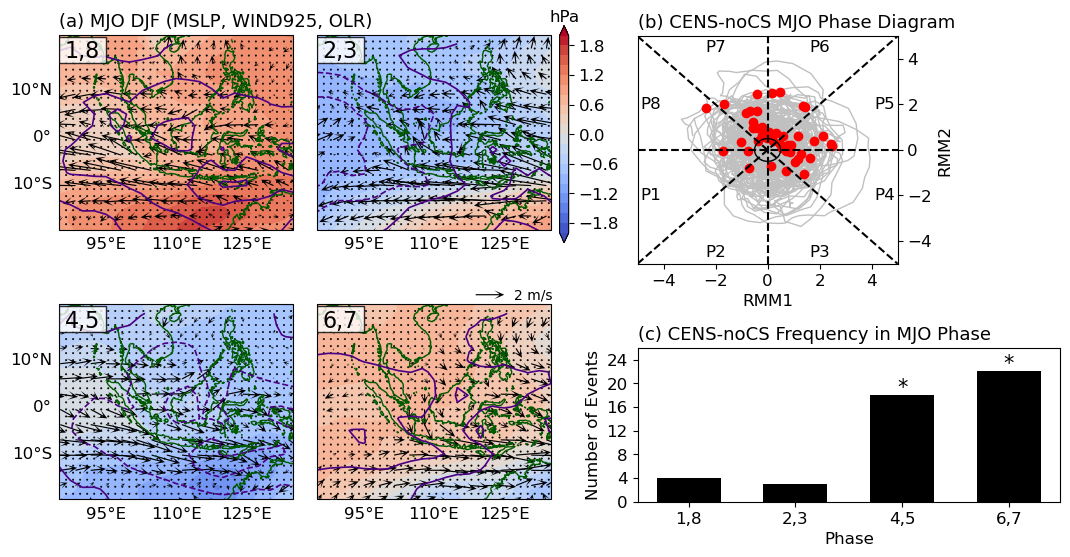

In [18]:
phasename=['1,8','2,3','4,5','6,7']
fig = plt.figure(figsize=(13,7))

#Plot MJO Phase Composite
for img, sbp in zip(np.arange(0,4,1), [241,242,245,246]):
    ax = fig.add_subplot(sbp, projection=ccrs.PlateCarree())
    ax.set_extent([85, 135, -18, 20])
    gl=ax.gridlines(draw_labels=True,linewidth=0)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlocator = tk.FixedLocator([95, 110, 125])
    gl.ylocator = tk.FixedLocator([-10, 0, 10])
    gl.xlabel_style = {'size': 12} 
    gl.ylabel_style = {'size': 12} 
    if img == 1 or img == 3:
        gl.left_labels = False
    pltctr=ax.contour(lonolr, latolr, olrdjfclim.sel(time=np.in1d(olrdjfclim.time, tglmjoeveryph4[img])).mean(dim='time'), 
              transform=ccrs.PlateCarree(),
              levels= [-20,-10,0,10,20], 
              extend='both', colors='indigo', linewidths=1.2
              )
    dset=slpdjfclim
    value=dset.sel(time=np.in1d(dset.time, tglmjoeveryph4[img])).mean(dim='time')
    plotval=ax.contourf(lon, lat, value, transform=ccrs.PlateCarree(),
              cmap='coolwarm',
              levels=np.arange(-2,2.2,0.2), extend='both'
              )
    x,y=np.meshgrid(lon, lat)
    skipp=6
    ax.scatter(x[::skipp,::skipp],y[::skipp,::skipp],pvaluemslptf4[img]*1,color='k', linewidth=0.4)
    uu=u925djfclim.sel(time=np.in1d(u925djfclim.time, tglmjoeveryph4[img])).mean(dim='time')
    vv=v925djfclim.sel(time=np.in1d(v925djfclim.time, tglmjoeveryph4[img])).mean(dim='time')
    skip = 13
    Qwd=ax.quiver(x[::skip, ::skip], y[::skip, ::skip], uu[::skip, ::skip]*pvalueuv925tf4[img], vv[::skip, ::skip]*pvalueuv925tf4[img], color='k', scale=7 ,scale_units='inches', width=0.005, headlength=8.5, headwidth=7.5, headaxislength=4)
    ax.add_feature(cfeature.COASTLINE, edgecolor='#005a00')
    if img==0:
        ax.set_title('(a) MJO DJF (MSLP, WIND925, OLR)', loc='left', fontsize=13)
    longitude1, latitude1 = 85, 16
    longitude2, latitude2 = 95, 21.5
    ax.add_patch(mpatches.Rectangle(xy=[longitude1, latitude1], width=longitude2-longitude1, height=latitude2-latitude1,
                                    facecolor='white', edgecolor='k', linewidth=1, alpha=0.8, zorder=3,
                                    transform=ccrs.PlateCarree()))
    ax.text(86.25,17,phasename[img],fontsize=16, c='k')
    if img==3:
        qk = plt.quiverkey(Qwd, 
                  0.8, 1.05,                  
                  2,str(2)+' m/s',   
                  labelpos='E',               
                  coordinates='axes'
                   )
cbar_ax = fig.add_axes([0.51, 0.53, 0.007, 0.31])
cbar = fig.colorbar(plotval, cax=cbar_ax)
cbar.ax.set_title('hPa', pad=10, fontsize=12)
cbar.ax.tick_params(labelsize=12)

#Plot Phase Diagram (MJO)
ax=fig.add_axes([0.57, 0.5, 0.2, 0.325])
ax.tick_params(labelsize=12)
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
ax.axhline(y=0, linestyle='--', c='k', zorder=4)
ax.axvline(x=0, linestyle='--', c='k', zorder=4)
ax.axline(xy1=(0, 0), slope=1, linestyle='--', c='k', zorder=4)
ax.axline(xy1=(0, 0), slope=-1, linestyle='--', c='k', zorder=4)
ax.text(2, -4.5, 'P3', horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.text(-2, -4.5, 'P2', horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.text(-2, 4.5, 'P7', horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.text(2, 4.5, 'P6', horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.text(4.5, 2, 'P5', horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.text(4.5, -2, 'P4', horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.text(-4.5, 2, 'P8', horizontalalignment='center', verticalalignment='center', fontsize=12)
ax.text(-4.5, -2, 'P1', horizontalalignment='center', verticalalignment='center', fontsize=12)
for year in np.arange(1979,2020,1):
    data=mjoevt.set_index('Tanggal').loc[pd.date_range(str(year)+'-12-01',str(year+1)+'-02-28')]
    plt.plot(data['RMM1'],data['RMM2'], c='silver', linewidth=1)
circle1=plt.Circle((0, 0), (0.5), color='k', fill=False, zorder=4)
ax.add_patch(circle1)
datanocs=mjoevt.set_index('Tanggal').loc[evt_cens_cs[0]]
ax.scatter(datanocs['RMM1'],datanocs['RMM2'], c='r', zorder=3)
ax.set_title('(b) CENS-noCS MJO Phase Diagram', loc='left', fontsize=13)
ax.set_xticks((np.arange(-4,4.1,2)))
ax.set_yticks((np.arange(-4,4.1,2)))
ax.set_xlabel('RMM1', fontsize=12)
ax.set_ylabel('RMM2', fontsize=12)
ax.yaxis.set_label_position("right")
ax.yaxis.set_ticks_position("right")

#Plot CENS-noCS Frequency in MJO Phase
ax = fig.add_axes([0.57, 0.16, 0.325, 0.22])
ax.bar(np.arange(1,4.1,1), ctcensmjo4, color='k', width=0.6)
ax.text(3,18.25,'*',fontsize=15, ha='center')
ax.text(4,22.25,'*',fontsize=15, ha='center')
ax.set_ylim([0,26])
ax.set_title('(c) CENS-noCS Frequency in MJO Phase', loc='left', fontsize=13)
ax.set_xlabel('Phase', fontsize=12)
ax.set_ylabel('Number of Events', fontsize=12)
ax.set_xticks((np.arange(1,5,1)))
ax.set_xticklabels(['1,8','2,3','4,5','6,7'],fontsize=12, rotation=0)
ax.set_yticks((np.arange(0,25,4)))
ax.set_yticklabels(np.arange(0,25,4),fontsize=12, rotation=0)

plt.subplots_adjust(hspace=0, wspace=0.1)
plt.savefig('figure_output\Fig 7.pdf', bbox_inches='tight')
plt.show()